# Segmentation 

This notebook shows how to use Stardist (Object Detection with Star-convex Shapes) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Load model of choice and segment an initial image to test Stardist parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from octopuslite import DaskOctopusLiteLoader
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from tqdm import tqdm
from skimage.io import imsave
import json
from scipy import ndimage as nd

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load images

In [36]:
# define experiment ID and select a position
expt = 'ND0011'
pos = 'Pos4'
expt_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}'
image_path = os.path.join(expt_path,f'{pos}_raw')
images = DaskOctopusLiteLoader(image_path, 
                               transforms=os.path.join(expt_path,'gfp_transform_tensor.npy'),
                               crop = (1200,1600))

Using cropping: (1200, 1600)


## 2. Load model and test segment single image 

In [34]:
### TRYING OUT DIFF MODELS AND EDITING MODELS

In [6]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')
model

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, tr

In [ ]:
train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8,
 train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0}, use_gpu=False

In [31]:
import h5py
filename = "/home/nathan/analysis/segment-classify-track/models/stardist_singleclass_MDCK/weights_best.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    print(a_group_key)
    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['concatenate', 'concatenate_1', 'concatenate_2', 'conv2d', 'conv2d_1', 'dist', 'down_level_0_no_0', 'down_level_0_no_1', 'down_level_1_no_0', 'down_level_1_no_1', 'down_level_2_no_0', 'down_level_2_no_1', 'features', 'features_class', 'input', 'max_0', 'max_1', 'max_2', 'max_pooling2d', 'middle_0', 'middle_2', 'prob', 'prob_class', 'up_level_0_no_0', 'up_level_0_no_2', 'up_level_1_no_0', 'up_level_1_no_2', 'up_level_2_no_0', 'up_level_2_no_2', 'up_sampling2d', 'up_sampling2d_1', 'up_sampling2d_2']>
concatenate


In [30]:
f.keys

<bound method MappingHDF5.keys of <Closed HDF5 file>>

In [32]:
model = StarDist2D(None, name='stardist_singleclass_MDCK', basedir='models')
model

Loading network weights from 'weights_best.h5'.


ValueError: You are trying to load a weight file containing 21 layers into a model with 19 layers.

In [2]:
model = StarDist2D(None, name='stardist_multiclass_MDCK', basedir='models')
model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.552369, nms_thresh=0.3.


StarDist2D(stardist_multiclass_MDCK): YXC → YXC
├─ Directory: /home/nathan/analysis/segment-classify-track/models/stardist_multiclass_MDCK
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=2, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=2, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 2], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2, 1], train_class_weights=[1, 1, 1], train_epochs=400, train_steps_per_epoch=100, train_learning_rat

In [164]:
# set test image index
frame = 1000
# load test image 
irfp = images['irfp'][frame]
rfp = images['rfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = irfp
img[:,:,1] = rfp
img.shape

(1200, 1600, 2)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


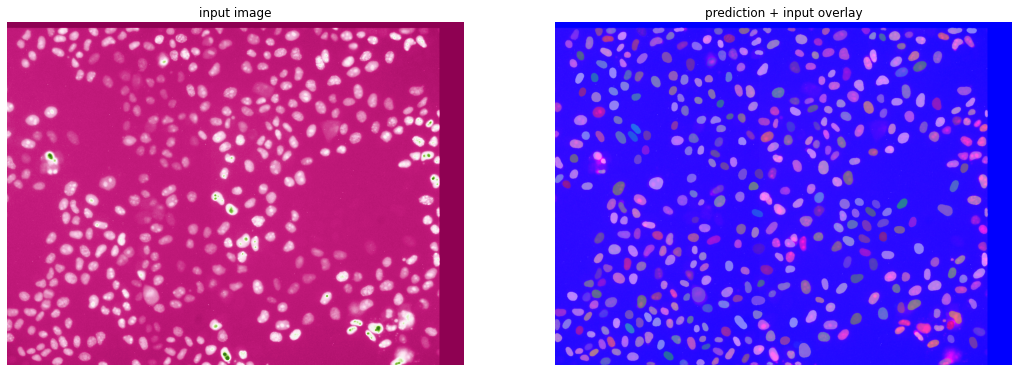

In [165]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


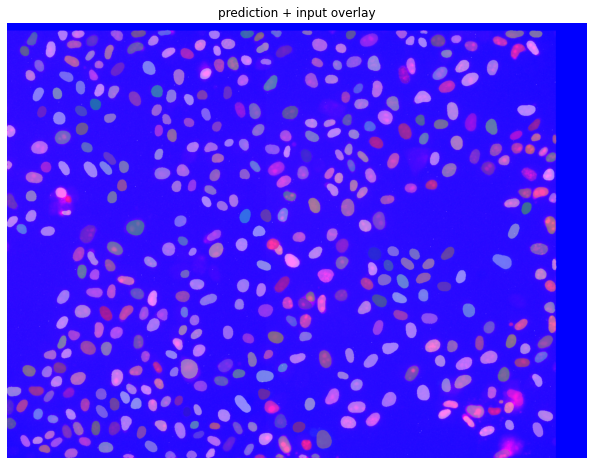

In [166]:
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

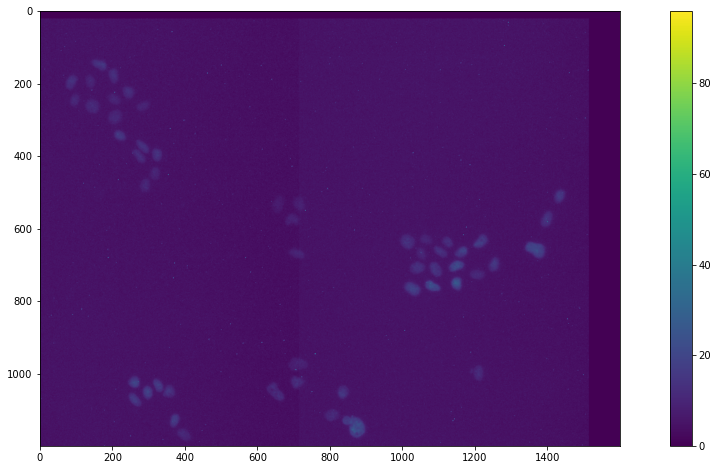

In [167]:
plt.imshow(img[:,:,1])
plt.colorbar()
plt.show()

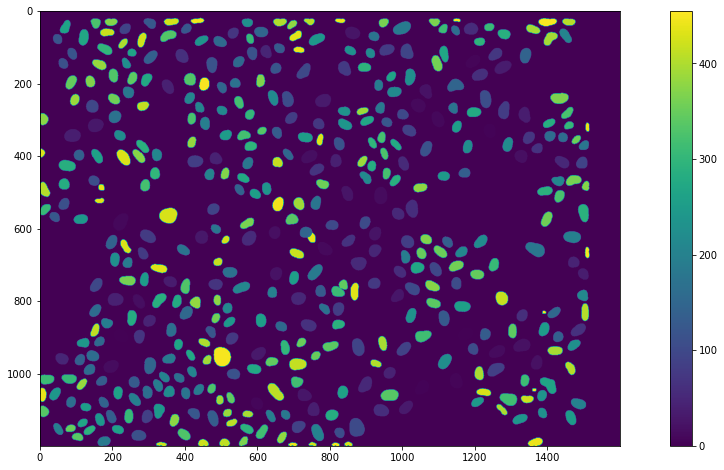

In [168]:
plt.imshow(labels)
plt.colorbar()
plt.show()

In [169]:
### testing multichannel acquisition

In [170]:
from scipy import ndimage as nd

In [176]:
rfp_count, gfp_count = 0, 0
mask = np.zeros(labels.shape)
# make multiclass mask from details dict
for cell_ID, class_label in enumerate(details['class_id'], 1):
    #needs erosion step to stop merging of labels
    segment = nd.binary_erosion(labels==cell_ID)
    mask[segment] = class_label
    if class_label == 2:
        rfp_count+=1 
    if class_label == 1:
        gfp_count+=1
# set background to zero
mask[labels == 0] = 0

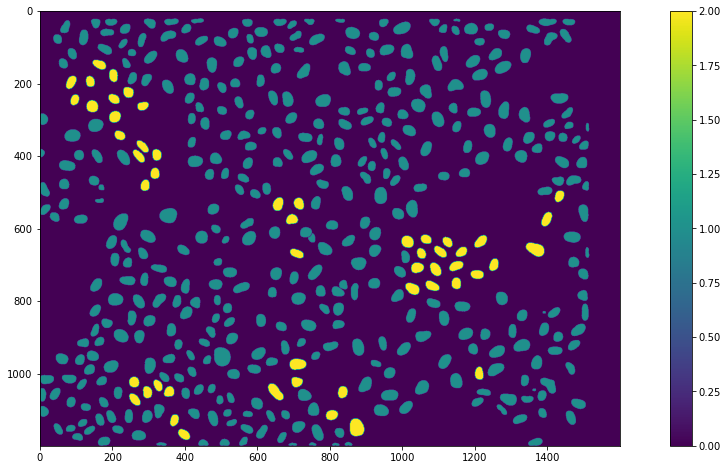

In [177]:
plt.imshow(mask)
plt.colorbar()
plt.show()

In [178]:
print('number of gfp', gfp_count, 'number of rfp', rfp_count)

number of gfp 403 number of rfp 52


In [186]:
print('old number of rfp', len(details['class_id']))

old number of rfp 53


In [192]:
print('old number of gfp', len(details['class_id']))

old number of gfp 422


# Running on just RFP channel

In [179]:
# set test image index
frame = 1000
# load test image 
gfp = images['gfp'][frame]
rfp = images['rfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = rfp
img[:,:,1] = rfp
img.shape

(1200, 1600, 2)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


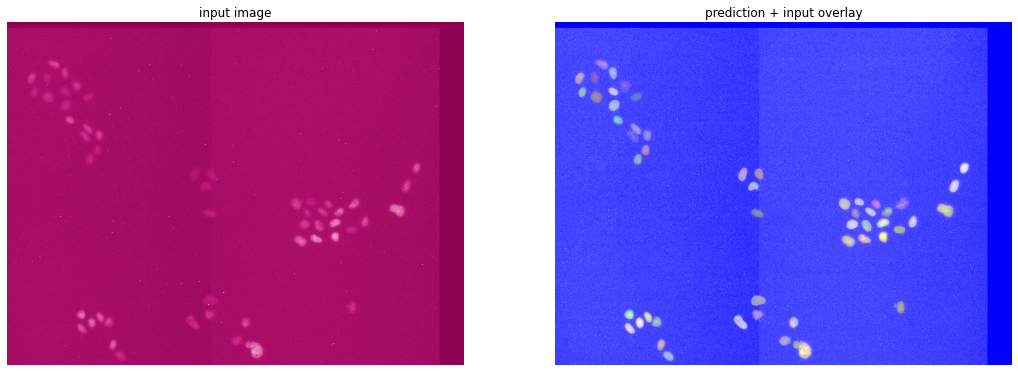

In [180]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


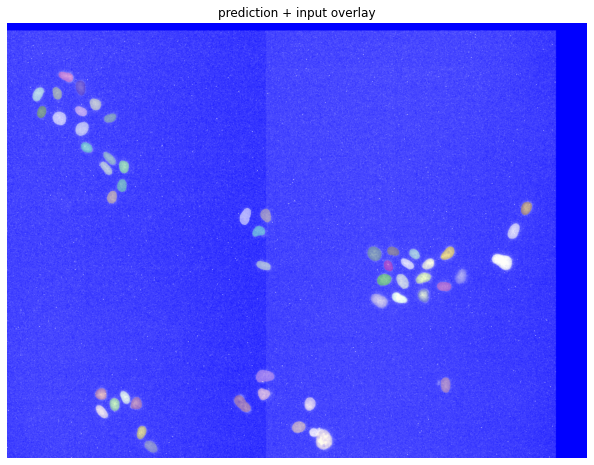

In [181]:
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

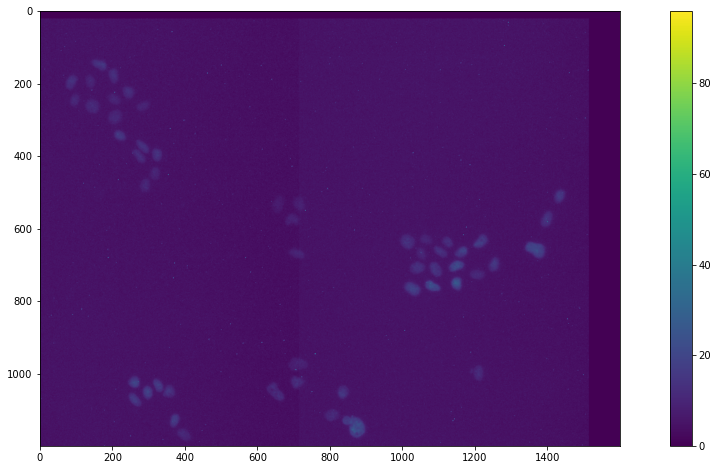

In [182]:
plt.imshow(img[:,:,0])
plt.colorbar()
plt.show()

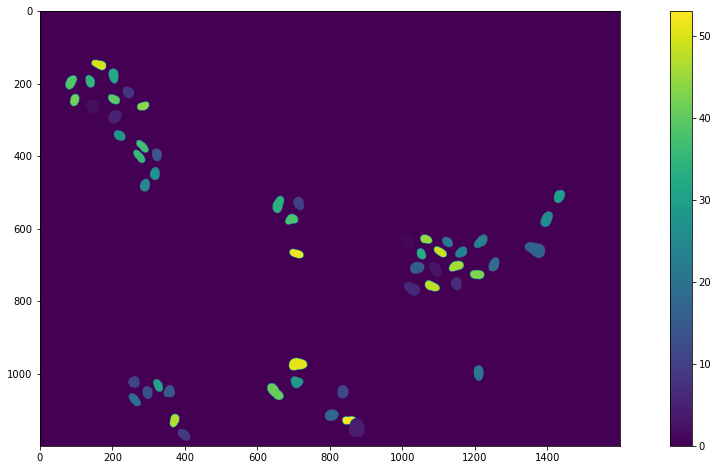

In [183]:
plt.imshow(labels)
plt.colorbar()
plt.show()

# Running on just iRFP channel

In [187]:
# set test image index
frame = 1000
# load test image 
irfp = images['irfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = irfp
img[:,:,1] = irfp
img.shape

(1200, 1600, 2)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


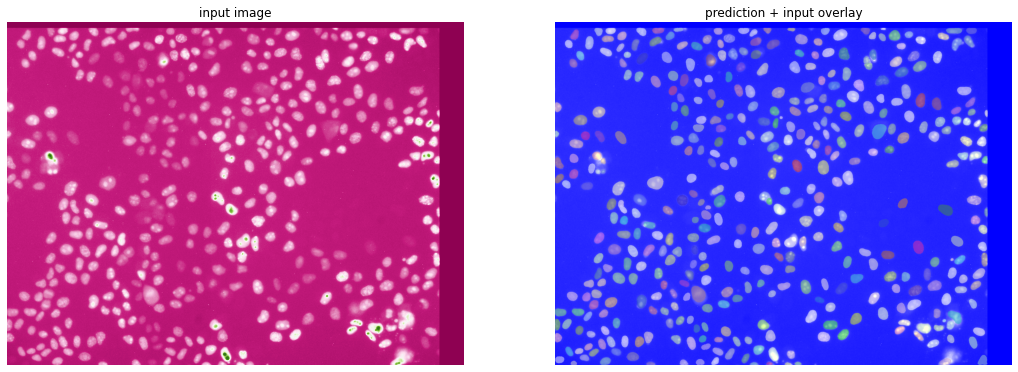

In [188]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


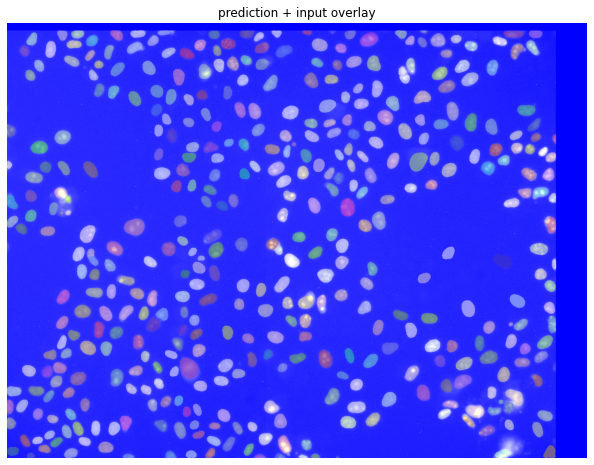

In [189]:
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

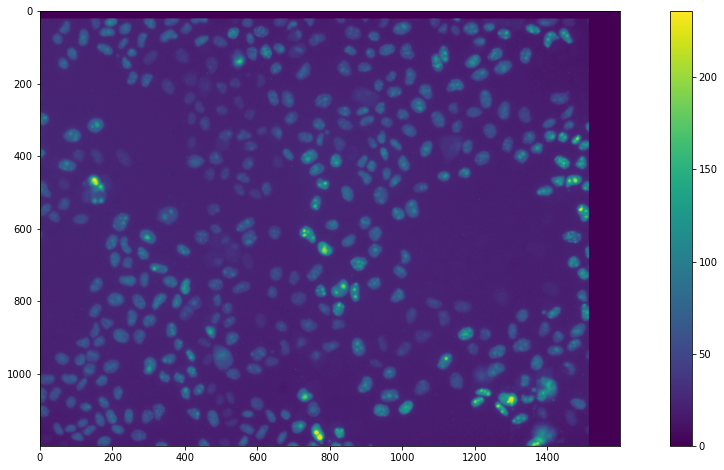

In [190]:
plt.imshow(img[:,:,0])
plt.colorbar()
plt.show()

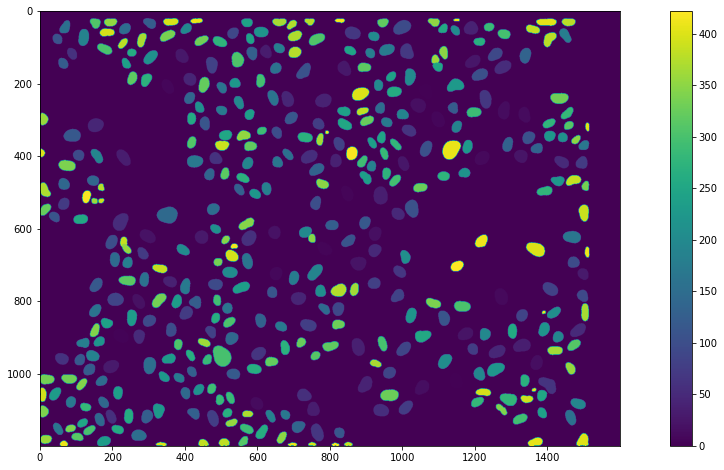

In [191]:
plt.imshow(labels)
plt.colorbar()
plt.show()

# Running on iRFP and RFP

In [88]:
# set test image index
#frame = 100
# load test image 
#irfp = images['irfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = irfp
img[:,:,1] = rfp
img.shape

(1352, 1688, 2)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


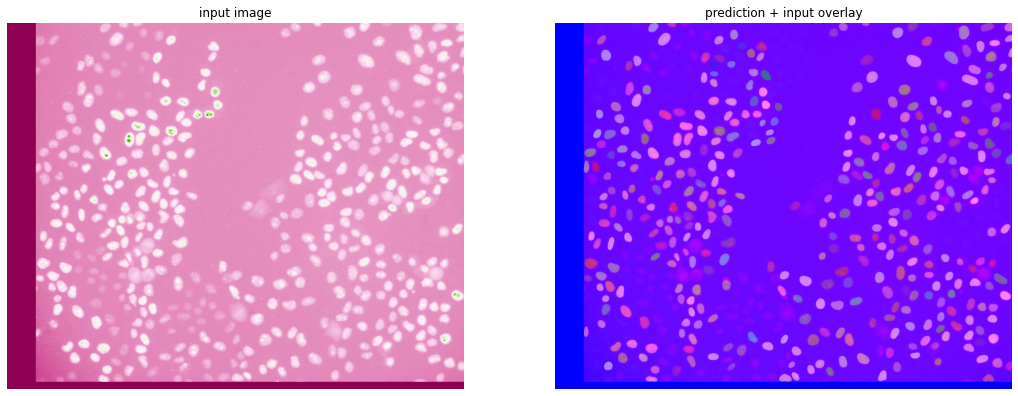

In [89]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


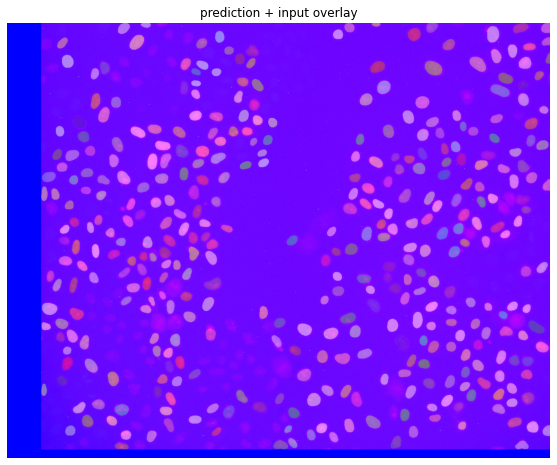

In [90]:
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

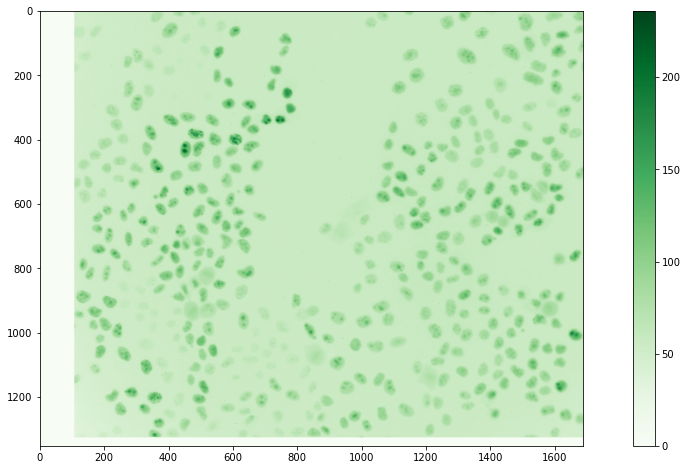

In [95]:
plt.imshow(img[:,:,0], cmap = 'Greens')
plt.colorbar()
plt.show()

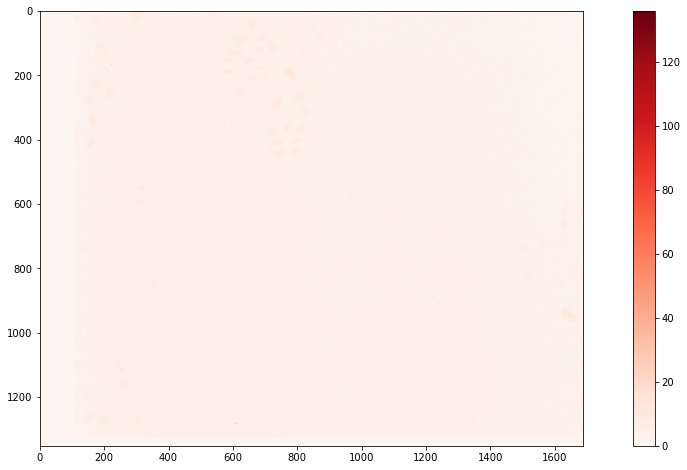

In [100]:
plt.imshow(img[:,:,1], cmap = 'Reds')
plt.colorbar()
plt.show()

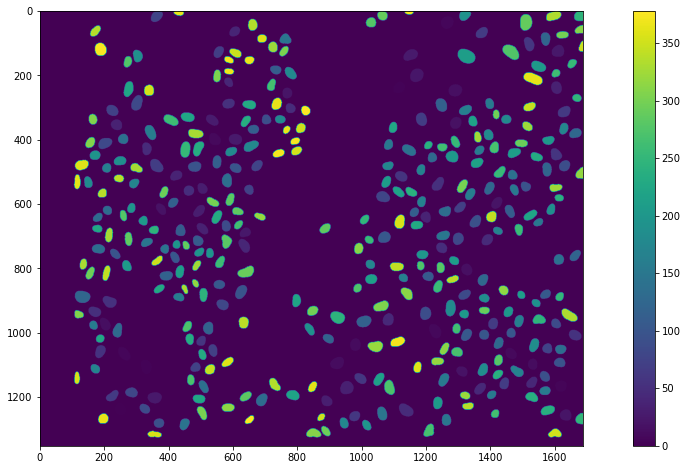

In [92]:
plt.imshow(labels)
plt.colorbar()
plt.show()

# checking out the multiclass labels of irfp rfp segmentation

In [77]:
details

{'coord': array([[[ 5.80000000e+01,  6.18197918e+01,  6.51660613e+01, ...,
           4.42887374e+01,  4.88520808e+01,  5.36337478e+01],
         [ 4.24823204e+02,  4.23203390e+02,  4.21300402e+02, ...,
           4.24520355e+02,  4.26085031e+02,  4.25950632e+02]],
 
        [[ 2.38000000e+02,  2.41679794e+02,  2.45077972e+02, ...,
           2.26461744e+02,  2.30162143e+02,  2.34091677e+02],
         [ 1.13557679e+03,  1.13449957e+03,  1.13308774e+03, ...,
           1.13326822e+03,  1.13492226e+03,  1.13564847e+03]],
 
        [[ 1.23600000e+03,  1.23944792e+03,  1.24321453e+03, ...,
           1.22729948e+03,  1.23001114e+03,  1.23285892e+03],
         [ 2.66937223e+02,  2.67333851e+02,  2.67417413e+02, ...,
           2.63021245e+02,  2.64458390e+02,  2.65791259e+02]],
 
        ...,
 
        [[ 6.00000000e+00,  8.71617471e+00,  1.08776193e+01, ...,
          -5.87057885e-01,  7.79445678e-01,  3.07568226e+00],
         [ 4.46853429e+02,  4.45655132e+02,  4.43775615e+02, ...,
     

## 3. Batch segment a whole stack of images

In [195]:
from skimage.io import imsave 
imsave('/home/nathan/data/kraken/ras/test_mask.tif', mask.astype(np.uint8))

<ipython-input-195-252938892822> (2): /home/nathan/data/kraken/ras/test_mask.tif is a low contrast image


In [204]:
from natsort import natsorted
natsorted([pos for pos in os.listdir('/home/nathan/data/kraken/ras/ND0009/') if 'Pos' in pos and os.path.isdir(os.path.join('/home/nathan/data/kraken/ras/ND0009/',pos))])

['Pos0',
 'Pos1',
 'Pos2',
 'Pos3',
 'Pos4',
 'Pos5',
 'Pos6',
 'Pos7',
 'Pos8',
 'Pos9',
 'Pos10',
 'Pos11']

In [210]:
for expt in ['ND0009', 'ND0010', 'ND0011']:
    for pos in ['Pos0',
                                 'Pos1',
                                 'Pos2',
                                 'Pos3',
                                 'Pos4',
                                 'Pos5',
                                 'Pos6',
                                 'Pos7',
                                 'Pos8',
                                 'Pos9',
                                 'Pos10',
                                 'Pos11']:
            # load images
            expt_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}'
            image_path = os.path.join(expt_path,f'{pos}_raw')
            if os.path.exists(image_path):
                os.rename(image_path, image_path.replace('raw', 'images'))

In [207]:
image_path

'/home/nathan/data/kraken/ras/ND0011/Pos2/Pos2_raw'

In [ ]:
%%time
for expt in tqdm(['ND0009', 'ND0010', 'ND0011'], position = 0, leave = True):
    for pos in tqdm(['Pos0',
                                 'Pos1',
                                 'Pos2',
                                 'Pos3',
                                 'Pos4',
                                 'Pos5',
                                 'Pos6',
                                 'Pos7',
                                 'Pos8',
                                 'Pos9',
                                 'Pos10',
                                 'Pos11'], position = 0, leave = True):
        print('Starting experiment position:', expt, pos)
        try:
            # load images
            expt_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}'
            image_path = os.path.join(expt_path,f'{pos}_images')
            images = DaskOctopusLiteLoader(image_path, 
                                           #transforms=os.path.join(expt_path,'gfp_transform_tensor.npy'),
                                           crop = (1200,1600))
            # set output directory for segmented images
    #         if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
    #             os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    
            for frame in tqdm(range(len(images['gfp'])), position = 0, leave = True):
                # compile 2-channels into XYC array
                img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
                img[:,:,0] = images['irfp'][frame]
                img[:,:,1] = images['rfp'][frame]
                # predict labels using 2ch image
                labels, details = model.predict_instances(normalize(img))
                # format 2channel mask image 
                mask = np.zeros(labels.shape)
                # make multiclass mask from details dict
                for cell_ID, class_label in enumerate(details['class_id'], 1):
                    #needs erosion step to stop merging of labels
                    segment = nd.binary_erosion(labels==cell_ID)
                    mask[segment] = class_label
                    # set background to zero
                    mask[labels == 0] = 0
                # set filename as mask format (channel099)
                fn = ((images.files('gfp')[frame])).replace('channel001', 'channel099')
                # save out labelled image
                imsave(fn, mask.astype(np.uint8), check_contrast=False)
    #             # save out details array ## need to work on this to finesse
    #             fn = fn.replace('.tif', '_details.npz')
    #             np.savez(fn, details)
        except Exception as e:
            print(expt, pos, "failed for some reason???")
            print(e)

  0%|          | 0/12 [00:00<?, ?it/s]

Starting experiment position: ND0009 Pos0
Using cropping: (1200, 1600)


  8%|▊         | 1/12 [39:13<7:11:32, 2353.84s/it]

Starting experiment position: ND0009 Pos1
Using cropping: (1200, 1600)


 17%|█▋        | 2/12 [1:53:17<9:57:12, 3583.27s/it]

Starting experiment position: ND0009 Pos2
Using cropping: (1200, 1600)


 25%|██▌       | 3/12 [2:46:52<8:32:16, 3415.18s/it]

Starting experiment position: ND0009 Pos3
Using cropping: (1200, 1600)


 33%|███▎      | 4/12 [4:02:10<8:33:24, 3850.61s/it]

Starting experiment position: ND0009 Pos4
Using cropping: (1200, 1600)


 42%|████▏     | 5/12 [5:03:10<7:21:10, 3781.52s/it]

Starting experiment position: ND0009 Pos5
Using cropping: (1200, 1600)


 50%|█████     | 6/12 [6:25:17<6:57:07, 4171.31s/it]

Starting experiment position: ND0009 Pos6
Using cropping: (1200, 1600)


 58%|█████▊    | 7/12 [6:53:02<4:39:19, 3351.84s/it]

Starting experiment position: ND0009 Pos7
Using cropping: (1200, 1600)


 67%|██████▋   | 8/12 [7:20:20<3:07:05, 2806.26s/it]

Starting experiment position: ND0009 Pos8
Using cropping: (1200, 1600)


 75%|███████▌  | 9/12 [7:50:08<2:04:23, 2487.76s/it]

Starting experiment position: ND0009 Pos9
Using cropping: (1200, 1600)


 83%|████████▎ | 10/12 [8:29:50<1:21:50, 2455.20s/it]

Starting experiment position: ND0009 Pos10
Using cropping: (1200, 1600)


 92%|█████████▏| 11/12 [9:12:23<41:25, 2485.26s/it]  

Starting experiment position: ND0009 Pos11
Using cropping: (1200, 1600)


  0%|          | 0/12 [00:00<?, ?it/s], 34896.74s/it]

Starting experiment position: ND0010 Pos0
Using cropping: (1200, 1600)


  8%|▊         | 1/12 [1:39:03<18:09:33, 5943.05s/it]

Starting experiment position: ND0010 Pos1
Using cropping: (1200, 1600)


 17%|█▋        | 2/12 [4:40:32<24:35:29, 8852.90s/it]

Starting experiment position: ND0010 Pos2
Using cropping: (1200, 1600)


 25%|██▌       | 3/12 [6:31:53<19:39:08, 7860.96s/it]

Starting experiment position: ND0010 Pos3
Using cropping: (1200, 1600)


 33%|███▎      | 4/12 [9:35:25<20:14:01, 9105.13s/it]

Starting experiment position: ND0010 Pos4
Using cropping: (1200, 1600)


 42%|████▏     | 5/12 [11:34:39<16:20:09, 8401.31s/it]

Starting experiment position: ND0010 Pos5
Using cropping: (1200, 1600)


 50%|█████     | 6/12 [13:27:15<13:04:12, 7842.08s/it]

Starting experiment position: ND0010 Pos6
Using cropping: (1200, 1600)


 58%|█████▊    | 7/12 [15:00:32<9:52:20, 7108.06s/it] 

Starting experiment position: ND0010 Pos7
Using cropping: (1200, 1600)


 67%|██████▋   | 8/12 [16:31:49<7:19:15, 6588.86s/it]

Starting experiment position: ND0010 Pos8
Using cropping: (1200, 1600)


 75%|███████▌  | 9/12 [17:55:11<5:04:37, 6092.66s/it]

Starting experiment position: ND0010 Pos9
Using cropping: (1200, 1600)


 83%|████████▎ | 10/12 [19:02:07<3:01:43, 5451.64s/it]

Starting experiment position: ND0010 Pos10
Using cropping: (1200, 1600)


 92%|█████████▏| 11/12 [20:13:52<1:25:00, 5100.68s/it]

Starting experiment position: ND0010 Pos11
Using cropping: (1200, 1600)


  0%|          | 0/12 [00:00<?, ?it/s]9, 59919.75s/it]

Starting experiment position: ND0011 Pos0
Using cropping: (1200, 1600)


  8%|▊         | 1/12 [1:34:24<17:18:33, 5664.87s/it]

Starting experiment position: ND0011 Pos1
Using cropping: (1200, 1600)


 17%|█▋        | 2/12 [3:22:23<17:03:56, 6143.60s/it]

Starting experiment position: ND0011 Pos2
Using cropping: (1200, 1600)


 25%|██▌       | 3/12 [6:40:44<21:55:51, 8772.39s/it]

Starting experiment position: ND0011 Pos3
Using cropping: (1200, 1600)


 88%|████████▊ | 1465/1657 [2:14:09<32:53, 10.28s/it]  

# need to configure blank frame skip in transform functions!!!

rerunning on untransformed images and then change octolite to accept mask transforms? need to sort this
or rerun and skip blank images according to condition set in transform? then integrate that into octolite? --> this didnt work for some reason to do with image shapes so running on all images and will neglect skipped frames using transforms (need to reintegrate into octolite)

check that all latest masks are after 1755 on 22/1

# Comparing a new 2-chan (irfp/rfp) seg with a 2x1-chan seg

In [103]:
%%time
for expt, pos in zip(['ND0009'], ['Pos2']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
        os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp']))):
        
        
        # compile 2-channels into single channel!!! XYC array
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['irfp'][frame]
        img[:,:,1] = images['irfp'][frame]
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # set filename as mask format (channel099)
        fn = ((images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')).replace('channel001', 'channel096')
        # save out labelled image
        imsave(fn, labels, check_contrast=False)
        # save out details array ## need to work on this to finesse
        fn = fn.replace('.tif', '_details_gfp.npz')
        np.savez(fn, details)
        
        ### and now rfp 
        
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['rfp'][frame]
        img[:,:,1] = images['rfp'][frame]
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # set filename as mask format (channel099)
        fn = ((images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')).replace('channel001', 'channel097')
        # save out labelled image
        imsave(fn, labels, check_contrast=False)
        # save out details array ## need to work on this to finesse
#         fn = fn.replace('.tif', '_details_rfp.npz')
#         np.savez(fn, details)

Starting experiment position: ND0009 Pos2
Using cropping: None


  2%|▏         | 20/1067 [00:41<36:05,  2.07s/it]


KeyboardInterrupt: 

# and now testing on pure population of ras

In [86]:
%%time
for expt, pos in zip(['ND0009'], ['Pos0']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
        os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp']))):
        # compile 2-channels into XYC array
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['gfp'][frame]
        img[:,:,1] = images['rfp'][frame]
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # set filename as mask format (channel099)
        fn = ((images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')).replace('channel001', 'channel099')
        # save out labelled image
        imsave(fn, labels, check_contrast=False)
        # save out details array ## need to work on this to finesse
        fn = fn.replace('.tif', '_details.npz')
        np.savez(fn, details)

Starting experiment position: ND0009 Pos0
Using cropping: None


100%|██████████| 1081/1081 [18:38<00:00,  1.03s/it]

CPU times: user 2h 18min 49s, sys: 19min 18s, total: 2h 38min 7s
Wall time: 18min 39s


# Comparing a typical 2-chan seg with a 2x1-chan seg

In [87]:
%%time
for expt, pos in zip(['ND0009'], ['Pos0']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
        os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp']))):
        
        
        # compile 2-channels into single channel!!! XYC array
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['gfp'][frame]
        img[:,:,1] = images['gfp'][frame]
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # set filename as mask format (channel099)
        fn = ((images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')).replace('channel001', 'channel098')
        # save out labelled image
        imsave(fn, labels, check_contrast=False)
        # save out details array ## need to work on this to finesse
        fn = fn.replace('.tif', '_details_gfp.npz')
        np.savez(fn, details)
        
        ### and now rfp 
        
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['rfp'][frame]
        img[:,:,1] = images['rfp'][frame]
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # set filename as mask format (channel099)
        fn = ((images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')).replace('channel001', 'channel097')
        # save out labelled image
        imsave(fn, labels, check_contrast=False)
        # save out details array ## need to work on this to finesse
        fn = fn.replace('.tif', '_details_rfp.npz')
        np.savez(fn, details)

Starting experiment position: ND0009 Pos0
Using cropping: None


100%|██████████| 1081/1081 [36:54<00:00,  2.05s/it]

CPU times: user 4h 42min 24s, sys: 38min 34s, total: 5h 20min 58s
Wall time: 36min 55s
